# Imports

In [1]:
# Standard library imports
import sys
import os

# Add path
sys.path.append(os.path.join('D:\\','OneDrive','Dokumente','Python','BMCSim'))

# Third party imports
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Local application imports
from BMCtool import BMCTool

# Settings

In [2]:
# simulation settings
n_timesteps = 100  # number of timesteps for each RF pulse
track = True  # track the magnetization trajectory during pulses/delays ?!
par_calc = True  # calculate all offsets in parallel instead of subsequently

# experimental settings
B0 = 3  # B0 in T
B1 = 1e-6  # B1 in T (for WASABI use 1.25e-6*B0)
n_p = 1  # number of saturation pulses
tp = 5  # pulse duration in s (for WASABI use 0.015/B0)
td = 0  # delay between pulses in s
shape = 'CW'
trec = 2.5  # recovery/delay time between offsets in s
offset = 10  # max offset in ppm
n_offsets = 101  # number of offsets

# sample settings
T1 = 2            #T1 in s
T2 = 0.2            #T2 in s

# CEST settings
n_pools = 2

#                bulk       1st       2nd       3rd       4th       5th       6th
T1n = np.array([   T1,       T1,       T1,       T1,       T1,       T1,       T1])
T2n = np.array([   T2,     0.15,     9e-6,     0.15,    0.015,     9e-6,    0.015])
fn  = np.array([    1,    0.002,     0.14,    0.005,    0.005,     0.14,     0.01])
dwn = np.array([ -0.0,        3,     -2.6,     -3.3,     -3.7,     -2.6,     -1.0])
kn  = np.array([    0,      500,       40,     2000,     2000,       40,      500])

# calculate offsets
offsets = np.linspace(-offset, offset, n_offsets)

# Simulate Z-spectrum

In [3]:
# create Sim object
Sim = BMCTool(b0=B0,
              n_pools=n_pools,
              t1_values=T1n,
              t2_values=T2n,
              poolsizes=fn,
              resonances=dwn,
              exchange_rates=kn,
              track=track)

if par_calc:
    # set initial magnetization
    Sim.set_M(offsets.shape[0])
 
    # simulate recovery
    Sim.solve(offsets, 0, trec, n_timesteps, shape=shape)

    # simulate saturation pulse train
    for n in range(n_p):
        # delay between pulses (not for the first pulse)
        if n != 0 and td != 0:
            Sim.solve(offsets, b1=0, pulse_dur=td, steps=int(td/tp*n_timesteps))
        # saturation
        Sim.solve(offsets, b1=B1, pulse_dur=tp, steps=int(n_timesteps), shape=shape)
        
    M = Sim.M_
else:
    # create array for magnetization values
    M = np.zeros([len(offsets), 3*n_pools, 1])
    
    # set initial magnetization
    Sim.set_M(1)

    for i in range(offsets.shape[0]):
        # simulate recovery
        Sim.solve(offsets[i], 0, trec, n_timesteps, shape='CW')

        # simulate saturation pulse train
        for n in range(n_p):
            if n != 0 and td != 0:
                Sim.solve(offsets[i], b1=0, pulse_dur=td, steps=int(td/tp*n_timesteps))
            Sim.solve(offsets[i], b1=B1, pulse_dur=tp, steps=int(n_timesteps), shape=shape)
        
        # write magnetization in array
        M[i,] = Sim.M_

# Create image stack of Shepp-Logan-style images 

## define phantom function

In [4]:
def phantom (n, ellipses):
    
    # Create blank image
    p = np.zeros((n, n))

    # Create the pixel grid
    ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n)]

    for ellip in ellipses:
        I   = ellip[0]
        a2  = ellip[1]**2
        b2  = ellip[2]**2
        x0  = ellip[3]
        y0  = ellip[4]
        phi = ellip[5]*np.pi/180  # Rotation angle in radians

        # Create the offset x and y values for the grid
        x = xgrid - x0
        y = ygrid - y0

        cos_p = np.cos (phi) 
        sin_p = np.sin (phi)

        # Find the pixels within the ellipse
        locs = (((x * cos_p + y * sin_p)**2) / a2 
              + ((y * cos_p - x * sin_p)**2) / b2) <= 1

        # Add the ellipse intensity to those pixels
        p[locs] += I

    return p

## define ellipses and image size

In [5]:
npx = 256
img_stack = np.zeros([n_offsets, npx, npx])

for i in range(n_offsets):
    e = [[    1,   .69,   .92,    0,      0,   0],
         [   -1, .1600, .4100, -.22,      0,  18],
         [+M[i,2], .1600, .4100, -.22,      0,  18],         
         [   -1, .1100, .3100,  .22,      0, -18],
         [+M[i,2], .1100, .3100,  .22,      0, -18]]
    
    img_stack[i,:,:] = phantom(n=npx, ellipses=e) 

## plot on-resonant image

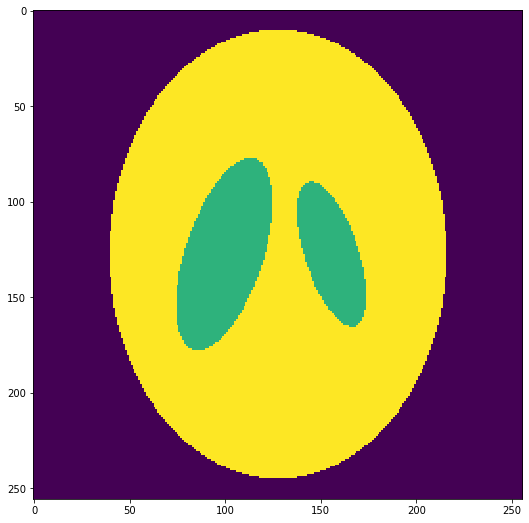

In [6]:
%matplotlib inline

# find index closest to CEST resonance
idx = int(np.where(offsets == offsets[np.abs(offsets - dwn[1]).argmin()])[0])

fig, ax = plt.subplots(figsize=(12,9))
tmp = ax.imshow(img_stack[idx,])